In [2]:
import pandas as pd

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [4]:
df = pd.read_csv('diamonds.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


In [6]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Колонки cut и price будут таргетами

In [7]:
df.isna().any()

carat      False
cut        False
color      False
clarity    False
depth      False
table      False
price      False
x          False
y          False
z          False
dtype: bool

## Как видно: мне повезло и в датасете нет пропушенных значений

In [8]:
df.color.value_counts()

color
G    11292
E     9797
F     9542
H     8304
D     6775
I     5422
J     2808
Name: count, dtype: int64

In [9]:
df.clarity.value_counts()

clarity
SI1     13065
VS2     12258
SI2      9194
VS1      8171
VVS2     5066
VVS1     3655
IF       1790
I1        741
Name: count, dtype: int64

# Для классификации cut я буду исаользовать все колонки, но для этого надо будет провести one-hot encoding в clarity (прозрачность) и color (цвет)

## хотя насчет цвета я не уверен, впрочем, дальше я проверю стоит ли с ним это делать или без

In [10]:
df_classification = df.copy()

In [11]:
df_classification = pd.get_dummies(df_classification, columns=['color', 'clarity'], drop_first=True)

In [12]:
pd.set_option('display.max_columns', None)

In [13]:
df_classification.head()

,carat,cut,depth,table,price,x,y,z,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,Ideal,61.5,55.0,326,3.95,3.98,2.43,True,False,False,False,False,False,False,False,True,False,False,False,False
1,0.21,Premium,59.8,61.0,326,3.89,3.84,2.31,True,False,False,False,False,False,False,True,False,False,False,False,False
2,0.23,Good,56.9,65.0,327,4.05,4.07,2.31,True,False,False,False,False,False,False,False,False,True,False,False,False
3,0.29,Premium,62.4,58.0,334,4.20,4.23,2.63,False,False,False,False,True,False,False,False,False,False,True,False,False
4,0.31,Good,63.3,58.0,335,4.34,4.35,2.75,False,False,False,False,False,True,False,False,True,False,False,False,False


# EDA

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


In [15]:
numeric_df = df.select_dtypes(include=['number'])  # Выбираем только числовые столбцы
correlation_matrix = numeric_df.corr()

In [16]:
correlation_matrix

,carat,depth,table,price,x,y,z
carat,1.000000,0.028224,0.181618,0.921591,0.975094,0.951722,0.953387
depth,0.028224,1.000000,-0.295779,-0.010647,-0.025289,-0.029341,0.094924
table,0.181618,-0.295779,1.000000,0.127134,0.195344,0.183760,0.150929
price,0.921591,-0.010647,0.127134,1.000000,0.884435,0.865421,0.861249
x,0.975094,-0.025289,0.195344,0.884435,1.000000,0.974701,0.970772
y,0.951722,-0.029341,0.183760,0.865421,0.974701,1.000000,0.952006
z,0.953387,0.094924,0.150929,0.861249,0.970772,0.952006,1.000000


интересно, что в описании к датасету написано, что depth это z / mean(x, y), те линейная комбинация, но зависимости, судя по матрице нет

а я думал, что тут будет мультиколлинеарность

In [17]:
def plot_hist(df, col):
    plt.hist(df[col])
    plt.axvline(df[col].mean(), color='r', linestyle='dashed', linewidth=3)
    plt.axvline(df[col].median(), color='g', linestyle='dashed', linewidth=3)
    plt.axvline(df[col].mean() - df[col].std(), color='y', linestyle='dashed', linewidth=3)
    plt.axvline(df[col].mean() + df[col].std(), color='y', linestyle='dashed', linewidth=3)
    plt.show()


In [18]:
df.columns

Index(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y',
       'z'],
      dtype='object')

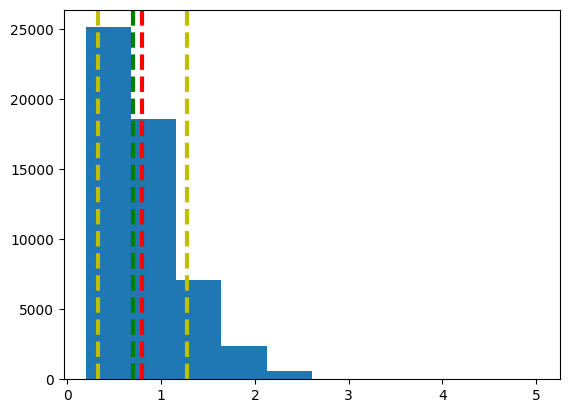

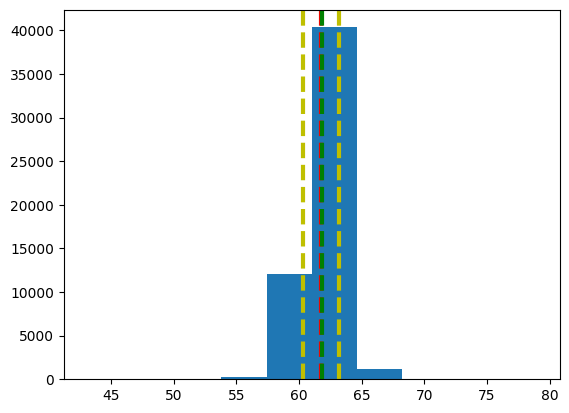

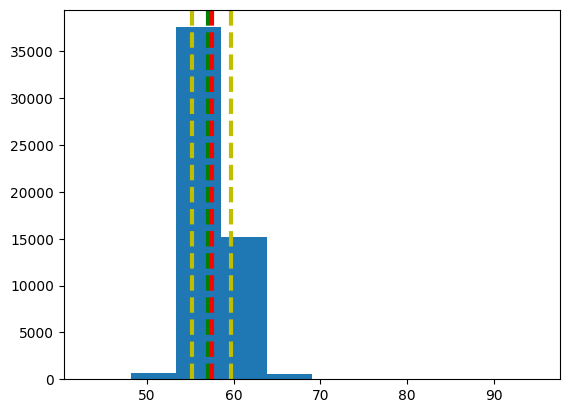

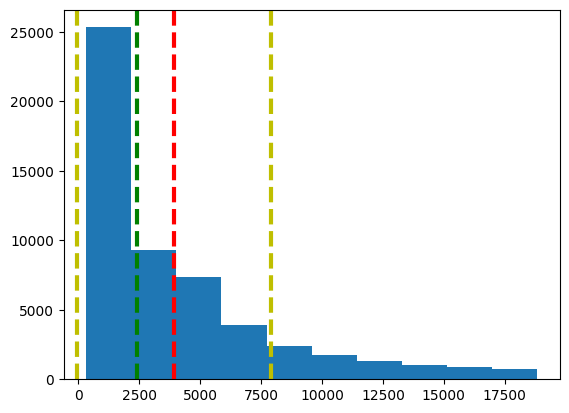

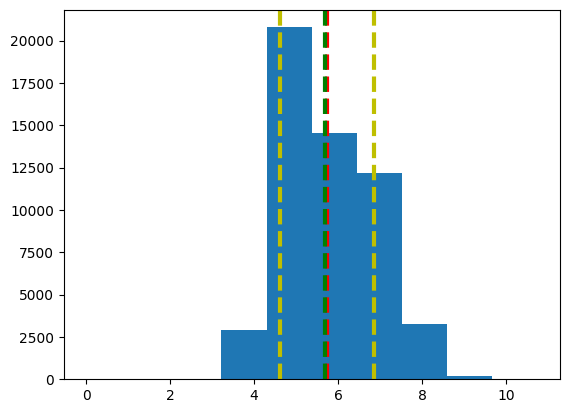

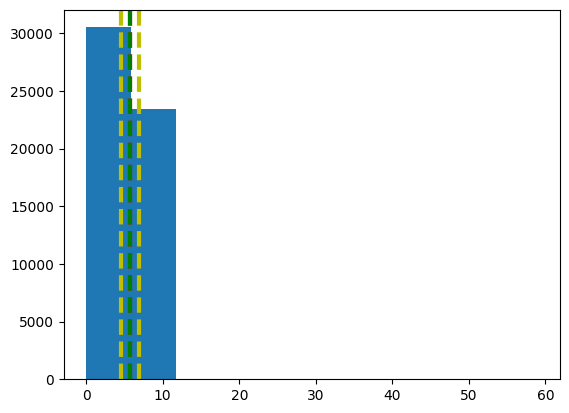

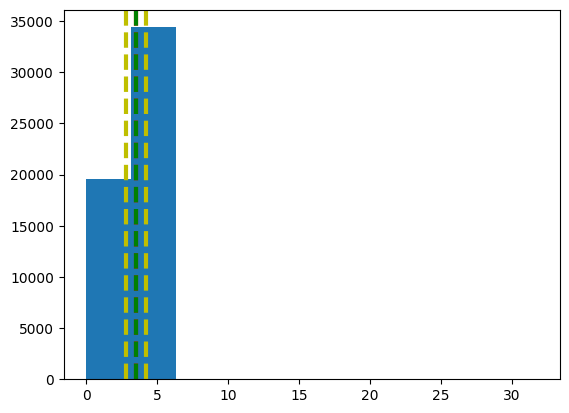

In [19]:
for i in ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']:
    plot_hist(df_classification, i)

In [20]:
def count_plot(df, col='None'):
    sns.countplot(x=col, data=df)
    plt.show()

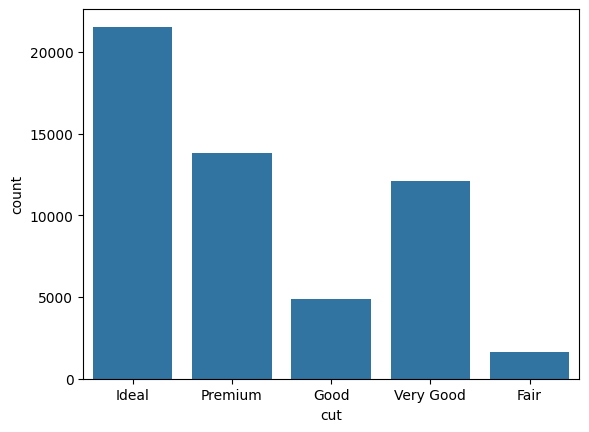

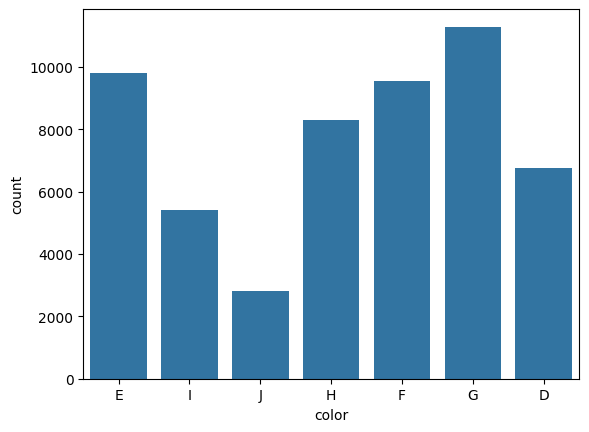

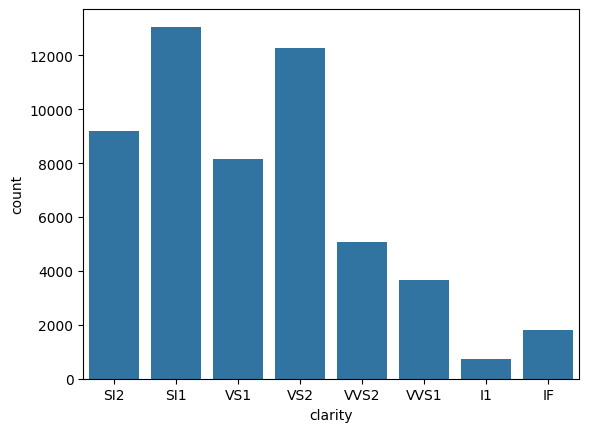

In [21]:
for i in ['cut', 'color', 'clarity']:
    count_plot(df, i)

тут вкратце имеется визуализация по столбцам, 2ю функцию я написал сам, но первая так была хороша и уникальна, что я не выдержал и взял ее у вас)

#### Также хочу отметить по первлму графику, что таргет (cut) не сбалансированный

### Выбросов в графиках с распределением я не вижу, и в целом, распределения у них околонормальные, хоть и с перекосами в одну из сторон (кроме графика по цене, разумеется)

## Теперь надо посмотреть, как признаки непосредственно влияют на таргет

In [22]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [23]:
df_classification.head()

,carat,cut,depth,table,price,x,y,z,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,Ideal,61.5,55.0,326,3.95,3.98,2.43,True,False,False,False,False,False,False,False,True,False,False,False,False
1,0.21,Premium,59.8,61.0,326,3.89,3.84,2.31,True,False,False,False,False,False,False,True,False,False,False,False,False
2,0.23,Good,56.9,65.0,327,4.05,4.07,2.31,True,False,False,False,False,False,False,False,False,True,False,False,False
3,0.29,Premium,62.4,58.0,334,4.20,4.23,2.63,False,False,False,False,True,False,False,False,False,False,True,False,False
4,0.31,Good,63.3,58.0,335,4.34,4.35,2.75,False,False,False,False,False,True,False,False,True,False,False,False,False


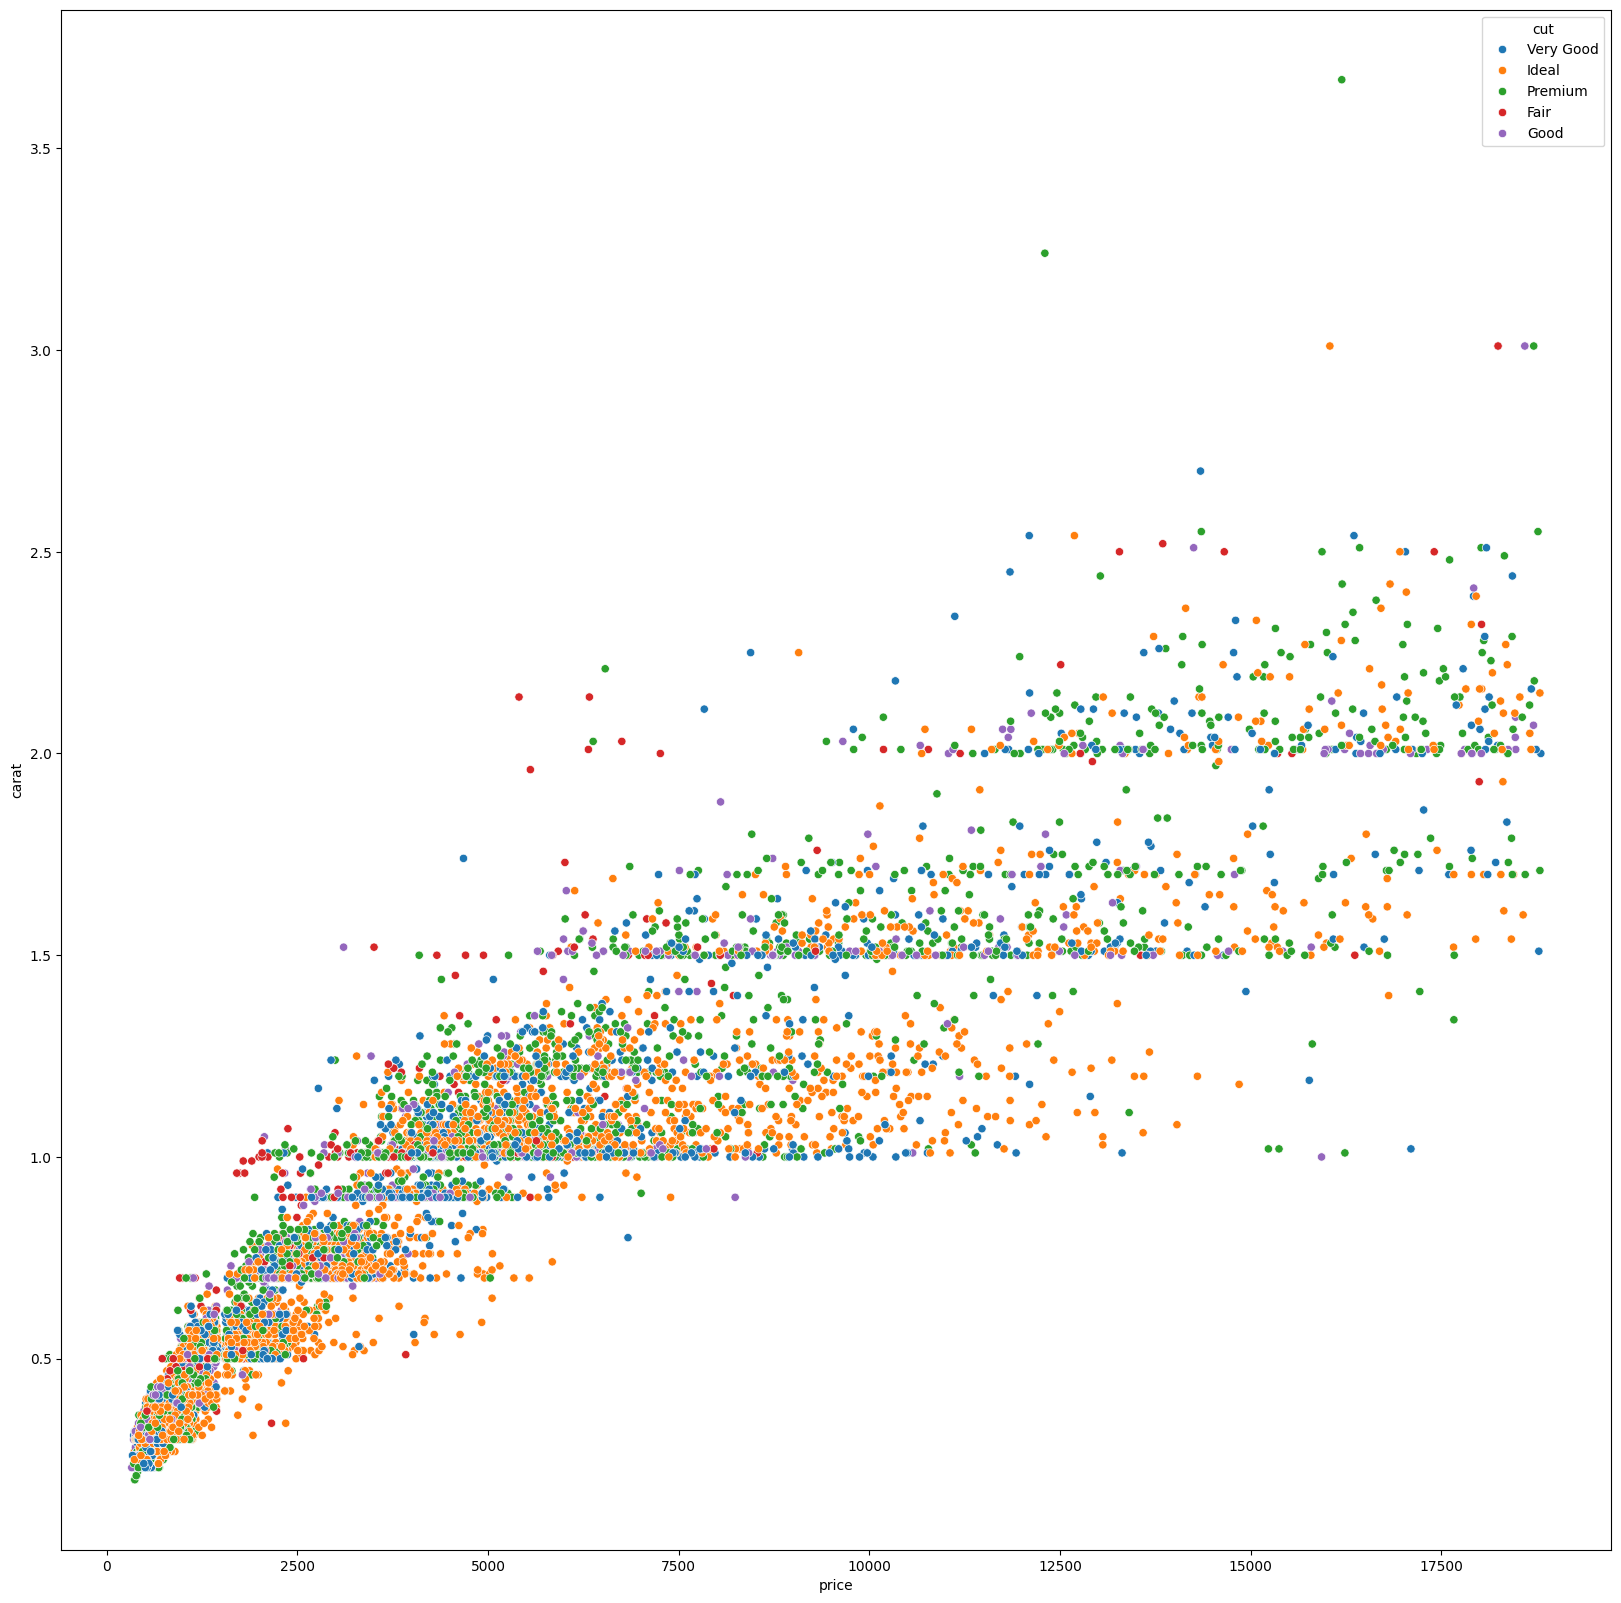

In [24]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x='price', y='carat', data=df_classification.sample(10000), hue='cut')
plt.show()

## Заметно, что с увеличением карата растет и цена для всех качеств, хотя после 1 карата уже цена сильно зависит от какчества, поэтому в подавляющем большинстве тут Ideal, Premium, Very Good
#### я взял примерно одну пятую датасета, потомму что все тупо не поместилось на графике

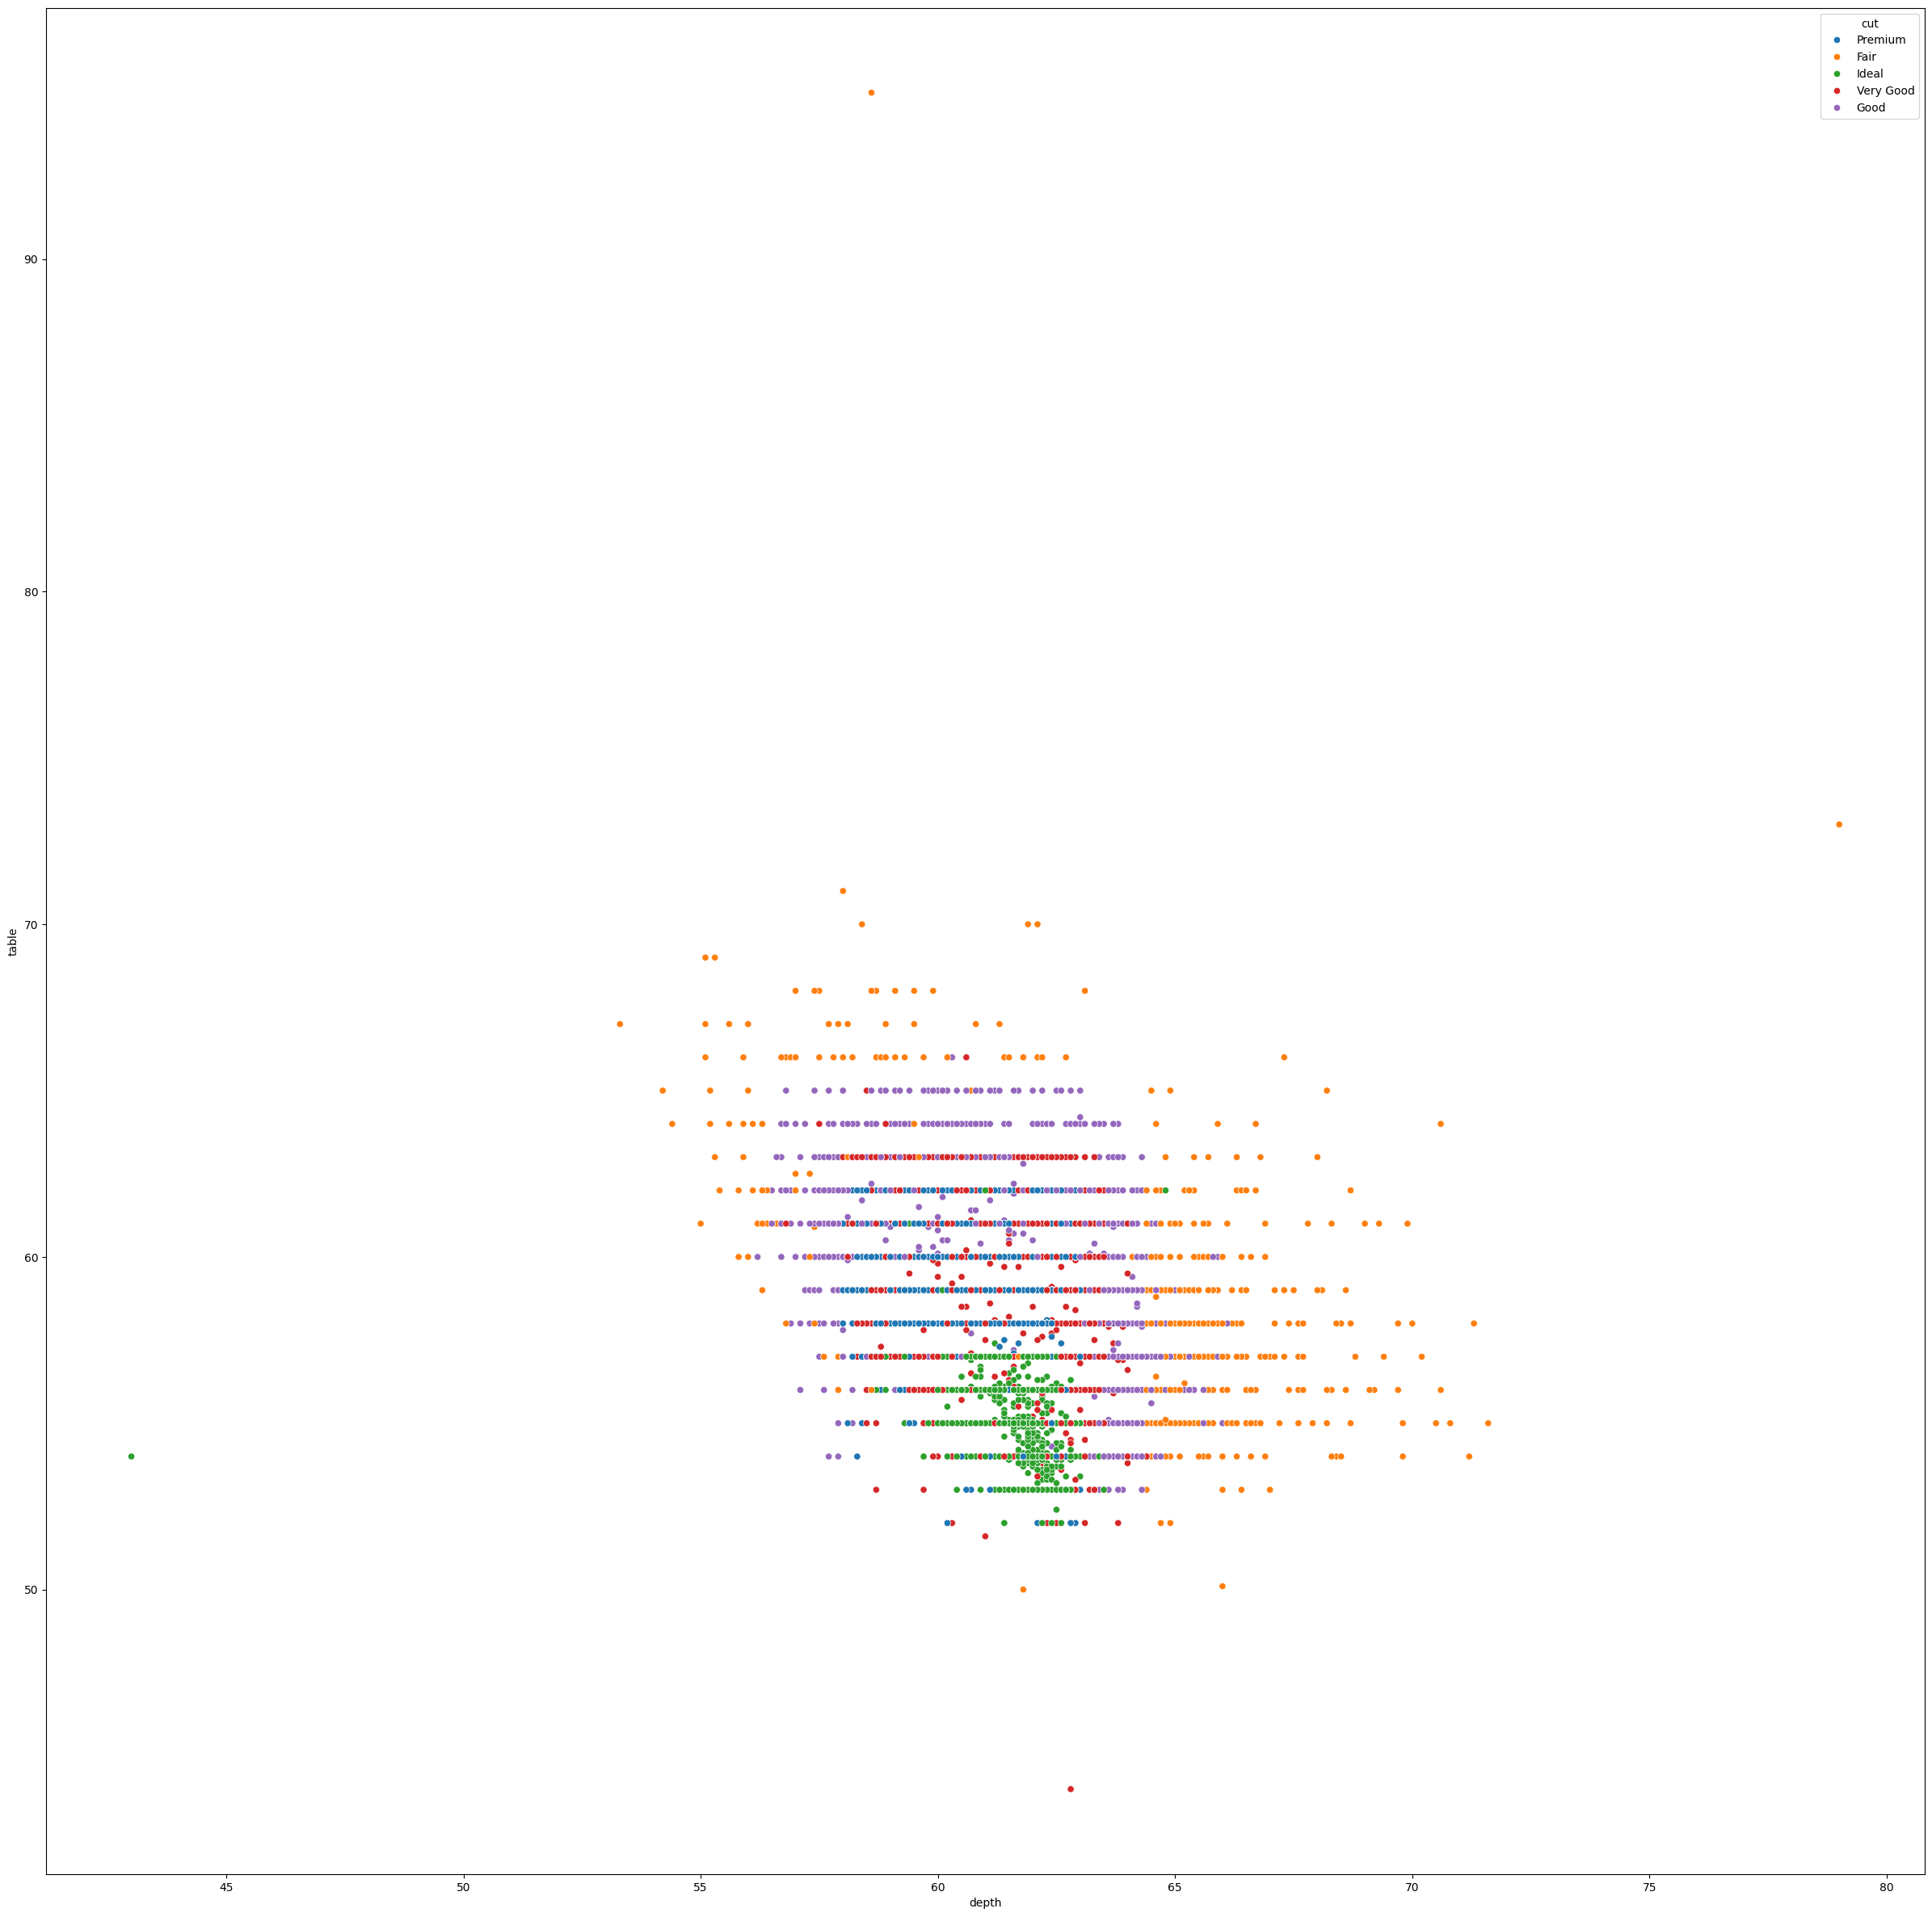

In [25]:
plt.figure(figsize=(30, 30))
sns.scatterplot(x='depth', y='table', data=df_classification.sample(20000), hue='cut')
plt.show()

## Интересно, что что алмазы более плохих качеств располагаются на внешних слоях в графике, те при увеличении глубины и диаметра в самой широкой части основания, а более качественные - ближе к центру

### Также здесь стали видны очевидные выбросы

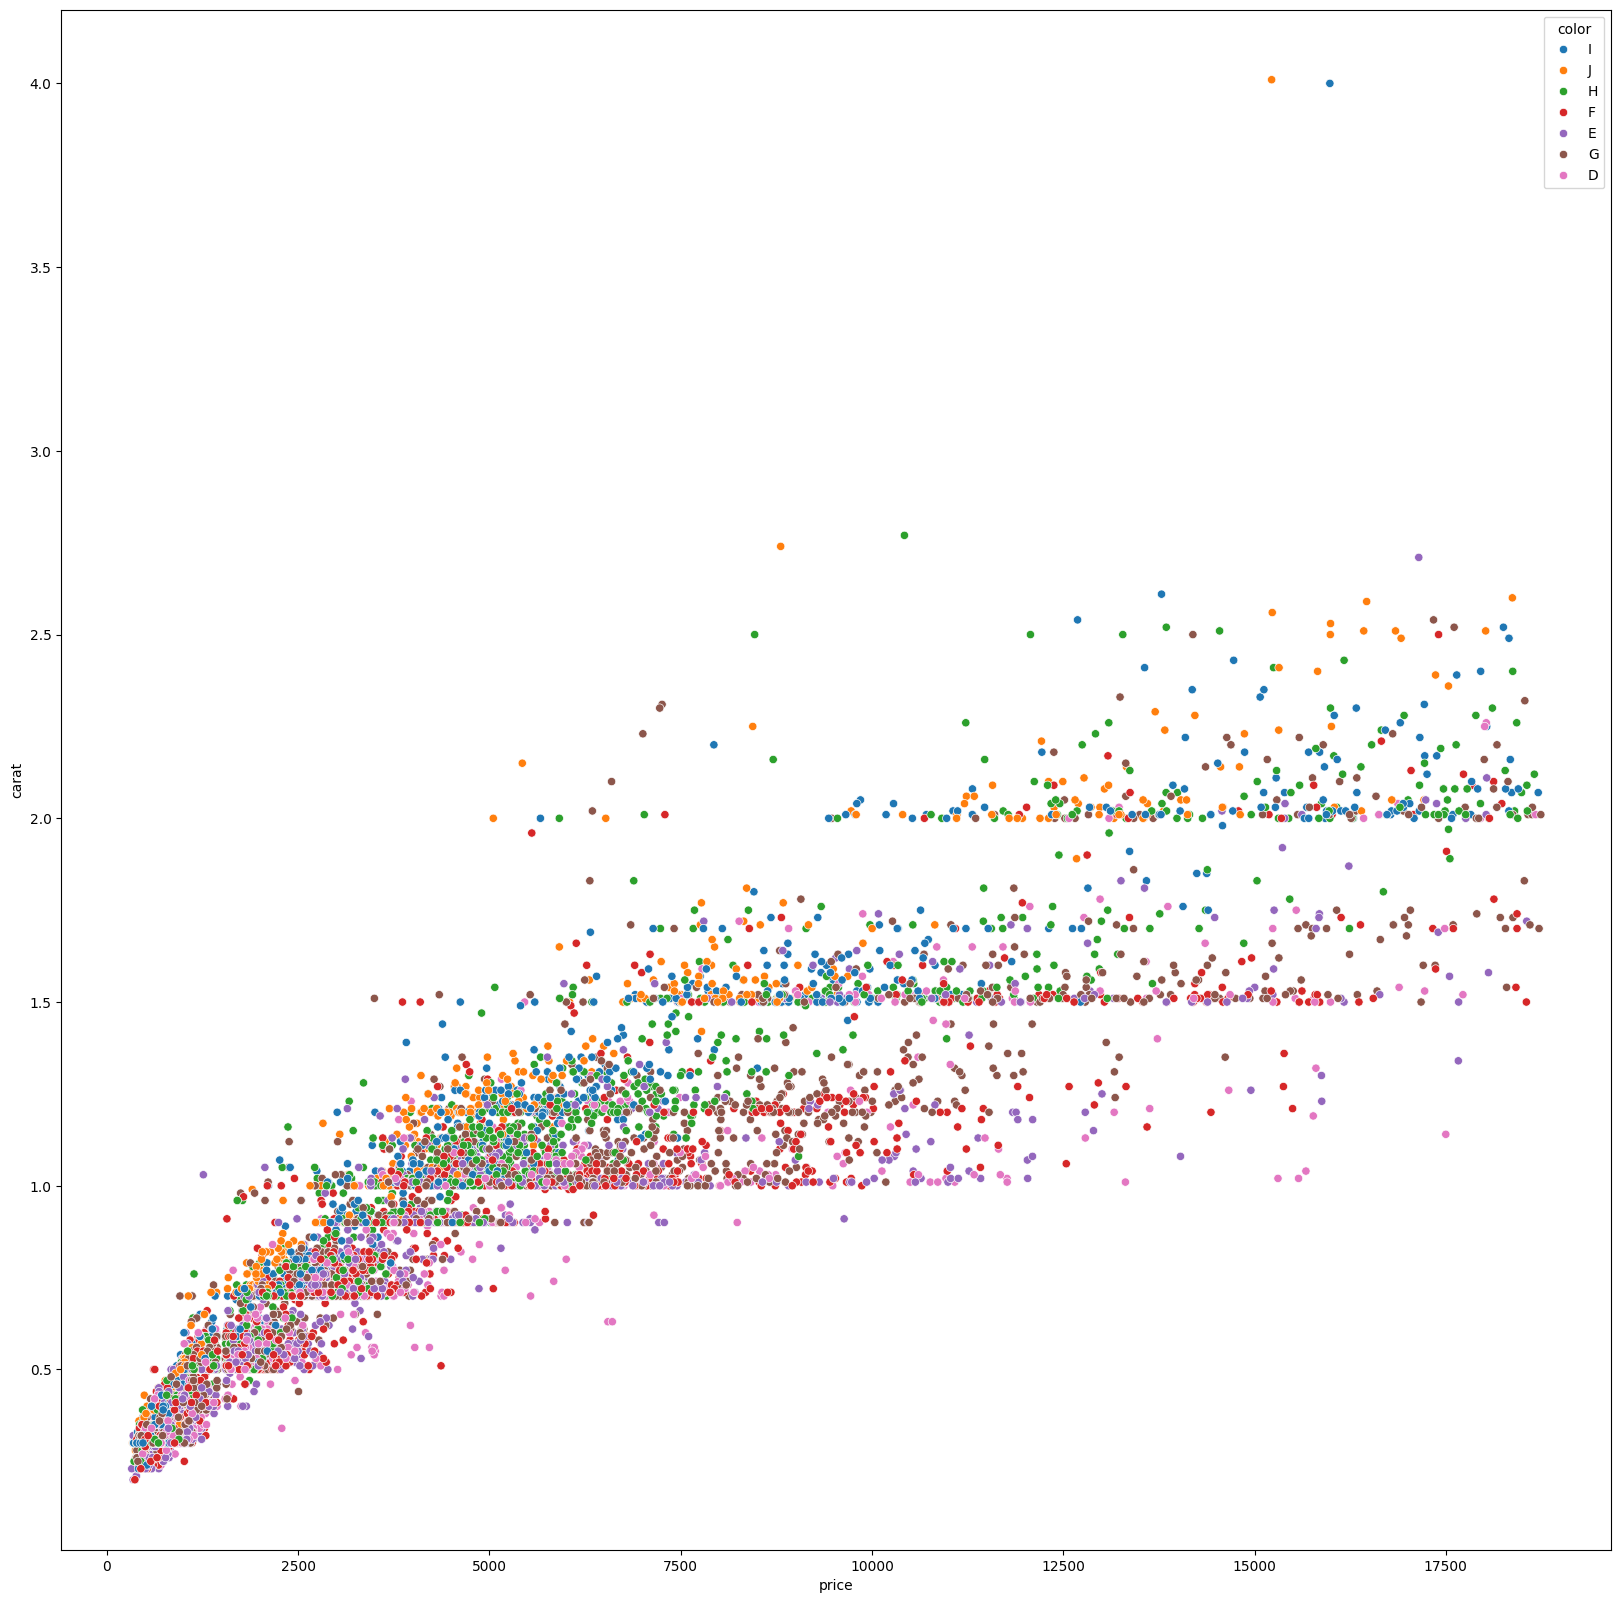

In [26]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x='price', y='carat', data=df.sample(10000), hue='color')
plt.show()

### Здесь я хотел посмотреть взаимосвязь цвета с основными характеристиками, но отчетливых зависимостей не вижу, хотя в описании датасета сказано, что цвета тоже бывают плохие и хорошие

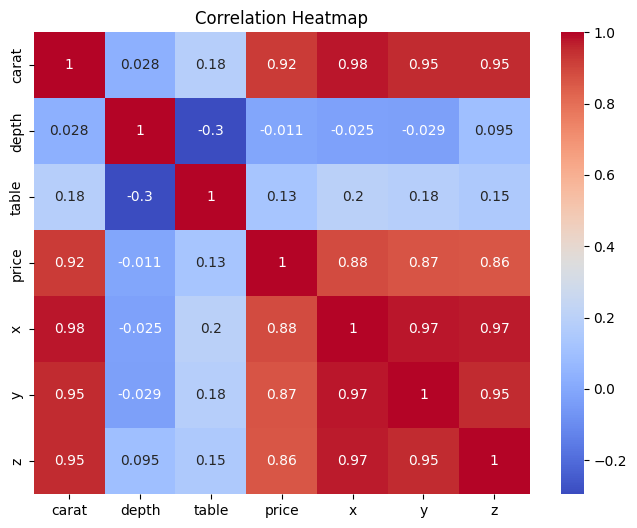

In [27]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.select_dtypes(include=['number']).corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

Эта матрица была выше, просто тут цветная

# Modeling

In [27]:
X = df_classification.drop('cut', axis=1)
y = df_classification['cut']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [28]:
model.feature_importances_

array([0.02700153, 0.24466097, 0.26629827, 0.10281463, 0.1198257 ,
       0.11605012, 0.03919081, 0.00761302, 0.008884  , 0.00825297,
       0.00744339, 0.00654644, 0.00306798, 0.00227535, 0.00721883,
       0.00657996, 0.00728946, 0.00803417, 0.0048647 , 0.00608771])

In [29]:
for i, j in zip(df_classification.drop('cut', axis=1).columns, model.feature_importances_):
    print(f'{i}: {j}')

carat: 0.027001526391401288
depth: 0.24466097118465524
table: 0.2662982688297966
price: 0.10281463035619988
x: 0.11982570008466947
y: 0.11605011806827399
z: 0.0391908092826525
color_E: 0.007613017408126645
color_F: 0.008884003820087458
color_G: 0.008252969590574095
color_H: 0.00744338676661236
color_I: 0.006546441858949306
color_J: 0.003067982129291672
clarity_IF: 0.0022753453914052427
clarity_SI1: 0.00721883269722463
clarity_SI2: 0.006579958519307128
clarity_VS1: 0.00728946372650801
clarity_VS2: 0.00803416648149749
clarity_VVS1: 0.00486469813357493
clarity_VVS2: 0.006087709279192064


In [30]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.72


In [31]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

        Fair       0.85      0.87      0.86       335
        Good       0.66      0.68      0.67      1004
       Ideal       0.81      0.80      0.80      4292
     Premium       0.75      0.74      0.75      2775
   Very Good       0.55      0.55      0.55      2382

    accuracy                           0.72     10788
   macro avg       0.72      0.73      0.73     10788
weighted avg       0.72      0.72      0.72     10788



# Эксперимент 1: Удалить не важные колонки

In [32]:
df_classification.columns

Index(['carat', 'cut', 'depth', 'table', 'price', 'x', 'y', 'z', 'color_E',
       'color_F', 'color_G', 'color_H', 'color_I', 'color_J', 'clarity_IF',
       'clarity_SI1', 'clarity_SI2', 'clarity_VS1', 'clarity_VS2',
       'clarity_VVS1', 'clarity_VVS2'],
      dtype='object')

In [33]:
not_impotant_features = ['cut', 'color_E',
       'color_F', 'color_G', 'color_H', 'color_I', 'color_J', 'clarity_IF',
       'clarity_SI1', 'clarity_SI2', 'clarity_VS1', 'clarity_VS2',
       'clarity_VVS1', 'clarity_VVS2']

In [34]:
X = df_classification.drop(not_impotant_features, axis=1)
y = df_classification['cut']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model1 = DecisionTreeClassifier(random_state=42)
model1.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [35]:
print("Evaluating model...")
y_pred1 = model1.predict(X_test)
accuracy1 = accuracy_score(y_test, y_pred1)
print(f"Accuracy: {accuracy:.2f}")

Evaluating model...
Accuracy: 0.72


In [36]:
print("Classification Report:")
print(classification_report(y_test, y_pred1))

Classification Report:
              precision    recall  f1-score   support

        Fair       0.88      0.87      0.87       335
        Good       0.67      0.70      0.69      1004
       Ideal       0.80      0.80      0.80      4292
     Premium       0.74      0.74      0.74      2775
   Very Good       0.54      0.53      0.53      2382

    accuracy                           0.72     10788
   macro avg       0.73      0.73      0.73     10788
weighted avg       0.72      0.72      0.72     10788



В некоторых объектах произошло небольшое улучшение, в то время как на последним чуть ухудшилось и классифицируется очень плохо

In [37]:
model2 = DecisionTreeClassifier(random_state=42, class_weight='balanced')
model2.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [38]:
y_pred2 = model1.predict(X_test)
accuracy2 = accuracy_score(y_test, y_pred2)
print("Classification Report:")
print(classification_report(y_test, y_pred2))

Classification Report:
              precision    recall  f1-score   support

        Fair       0.88      0.87      0.87       335
        Good       0.67      0.70      0.69      1004
       Ideal       0.80      0.80      0.80      4292
     Premium       0.74      0.74      0.74      2775
   Very Good       0.54      0.53      0.53      2382

    accuracy                           0.72     10788
   macro avg       0.73      0.73      0.73     10788
weighted avg       0.72      0.72      0.72     10788



Балансировка классов ничего не изменила

In [39]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

errors = X_test[y_test != y_pred]
print(errors.head())

[[ 290   32    3    7    3]
 [  37  682   26   29  230]
 [   3   30 3442  303  514]
 [   5   48  312 2061  349]
 [   6  239  478  339 1320]]
       carat  depth  table  price     x     y     z
42377   0.43   60.8   57.0   1304  4.92  4.89  2.98
46398   0.51   60.2   56.0   1765  5.22  5.24  3.15
24772   1.83   62.8   56.0  13134  7.76  7.82  4.89
27497   2.07   61.2   58.0  18193  8.18  8.20  5.01
19771   1.04   59.1   56.0   8341  6.65  6.59  3.91


Very Good часто путается с Good (239 раз), Ideal (505 раз) и Premium (362 раза). Возможно, признаки для классов Very Good, Ideal и других сильно пересекаются.

### Возможно, нужно подумать над новыми признаками, но пока я не знаю

In [40]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [41]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

Accuracy: 0.55


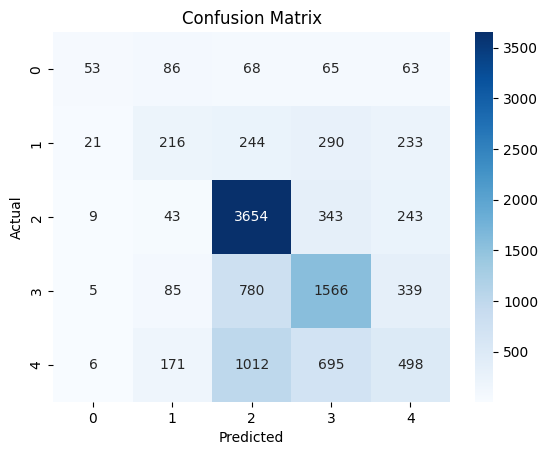

Classification Report:
              precision    recall  f1-score   support

        Fair       0.56      0.16      0.25       335
        Good       0.36      0.22      0.27      1004
       Ideal       0.63      0.85      0.73      4292
     Premium       0.53      0.56      0.55      2775
   Very Good       0.36      0.21      0.27      2382

    accuracy                           0.55     10788
   macro avg       0.49      0.40      0.41     10788
weighted avg       0.52      0.55      0.52     10788



In [42]:
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred))

KNN предсказал хуже

In [43]:
RANDOM_STATE = 42

In [44]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [45]:
logreg = LogisticRegression(random_state=RANDOM_STATE,max_iter=1000, class_weight='balanced')
logreg.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

Accuracy: 0.58


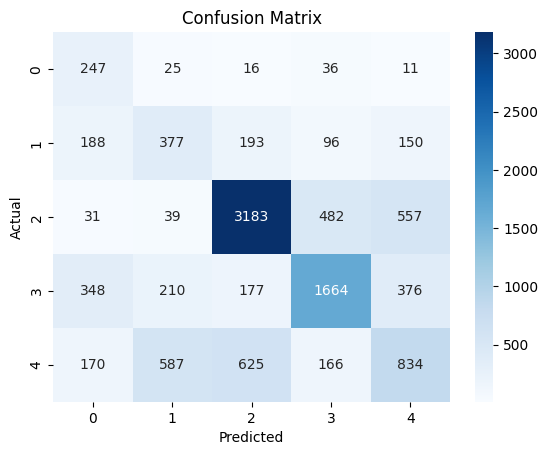

Classification Report:
              precision    recall  f1-score   support

        Fair       0.25      0.74      0.37       335
        Good       0.30      0.38      0.34      1004
       Ideal       0.76      0.74      0.75      4292
     Premium       0.68      0.60      0.64      2775
   Very Good       0.43      0.35      0.39      2382

    accuracy                           0.58     10788
   macro avg       0.49      0.56      0.50     10788
weighted avg       0.61      0.58      0.59     10788



In [46]:
y_pred = logreg.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred))

### В лог регрессии было все плохо, из за чего мне пришлось увеличить кол-во итераций, ввести параметр балансировки классов и провести масштабирование StandardScaler, пока результат выдается хуже, чем через деревья

In [47]:
svc = SVC(class_weight='balanced', random_state=42)
svc.fit(X_train_scaled, y_train)

SVC(class_weight='balanced', random_state=42)

Accuracy: 0.58


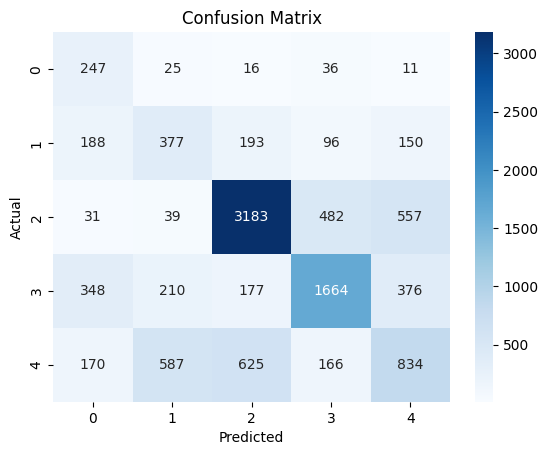

Classification Report:
              precision    recall  f1-score   support

        Fair       0.25      0.74      0.37       335
        Good       0.30      0.38      0.34      1004
       Ideal       0.76      0.74      0.75      4292
     Premium       0.68      0.60      0.64      2775
   Very Good       0.43      0.35      0.39      2382

    accuracy                           0.58     10788
   macro avg       0.49      0.56      0.50     10788
weighted avg       0.61      0.58      0.59     10788



In [48]:
y_pred_svc = logreg.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred_svc)
print(f"Accuracy: {accuracy:.2f}")

cm = confusion_matrix(y_test, y_pred_svc)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred_svc))

### Здесь, результат почему то аналогичен лог регресии, попробую сделать еще кое что

В любом случае, они оба лучше чем kNN

In [49]:
from imblearn.over_sampling import SMOTE

In [50]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)
logreg.fit(X_resampled, y_resampled)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

<Axes: xlabel='count', ylabel='cut'>

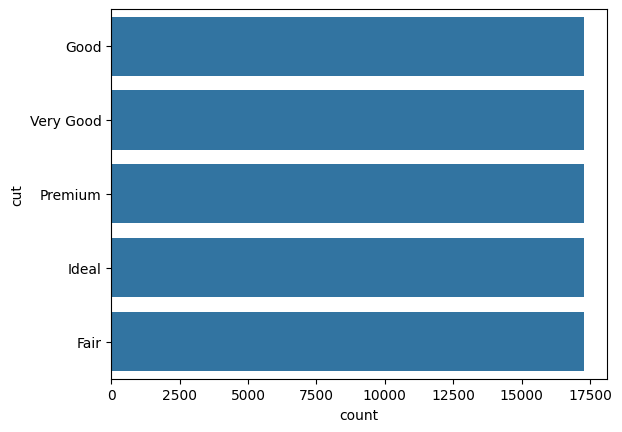

In [51]:
sns.countplot(y_resampled)

Accuracy: 0.58


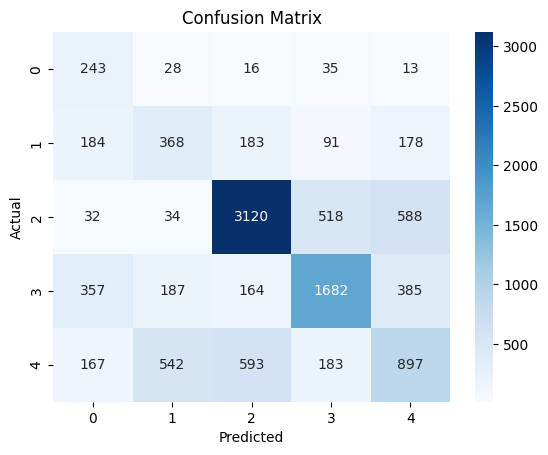

Classification Report:
              precision    recall  f1-score   support

        Fair       0.25      0.73      0.37       335
        Good       0.32      0.37      0.34      1004
       Ideal       0.77      0.73      0.75      4292
     Premium       0.67      0.61      0.64      2775
   Very Good       0.44      0.38      0.40      2382

    accuracy                           0.58     10788
   macro avg       0.49      0.56      0.50     10788
weighted avg       0.61      0.58      0.59     10788



In [52]:
y_pred_log = logreg.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred_log)
print(f"Accuracy: {accuracy:.2f}")

cm = confusion_matrix(y_test, y_pred_log)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred_log))

### У лог регрессии чуть-чуть улучшило

Теперь попробую SVM с smote

In [53]:
svc.fit(X_resampled, y_resampled)

SVC(class_weight='balanced', random_state=42)

Accuracy: 0.75


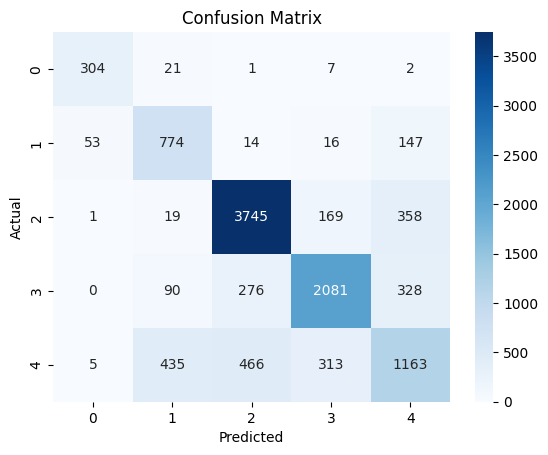

Classification Report:
              precision    recall  f1-score   support

        Fair       0.84      0.91      0.87       335
        Good       0.58      0.77      0.66      1004
       Ideal       0.83      0.87      0.85      4292
     Premium       0.80      0.75      0.78      2775
   Very Good       0.58      0.49      0.53      2382

    accuracy                           0.75     10788
   macro avg       0.73      0.76      0.74     10788
weighted avg       0.75      0.75      0.74     10788



In [54]:
y_pred_svc = svc.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred_svc)
print(f"Accuracy: {accuracy:.2f}")

cm = confusion_matrix(y_test, y_pred_svc)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred_svc))

### Результат стал гораздо лучше!

хотя Very Good по-прежнему плохо классифицируется

теперь попробую бустинги

In [55]:
from xgboost import XGBClassifier

In [56]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Оригинальные классы:", label_encoder.classes_)
print("Числовые метки:", set(y_encoded))

Оригинальные классы: ['Fair' 'Good' 'Ideal' 'Premium' 'Very Good']
Числовые метки: {0, 1, 2, 3, 4}


## Оказывается у надо заэнкодить чтобы бустинг работал

In [57]:
from xgboost import plot_importance

In [58]:
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train_encoded)


G:\Python 3.11\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:14:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [59]:
y_pred_xgb = model.predict(X_test)
print(classification_report(y_test_encoded, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.91      0.90      0.91       335
           1       0.80      0.71      0.75      1004
           2       0.82      0.92      0.87      4292
           3       0.82      0.81      0.82      2775
           4       0.69      0.59      0.64      2382

    accuracy                           0.80     10788
   macro avg       0.81      0.79      0.80     10788
weighted avg       0.79      0.80      0.79     10788



In [60]:
conf_matrix = confusion_matrix(y_test_encoded, y_pred_xgb)
print(conf_matrix)

[[ 302   20    3    7    3]
 [  24  710   20   16  234]
 [   1   10 3944  156  181]
 [   1    4  310 2258  202]
 [   4  149  520  304 1405]]


Оригинальные классы: ['Fair' 'Good' 'Ideal' 'Premium' 'Very Good']
Числовые метки: {0, 1, 2, 3, 4}

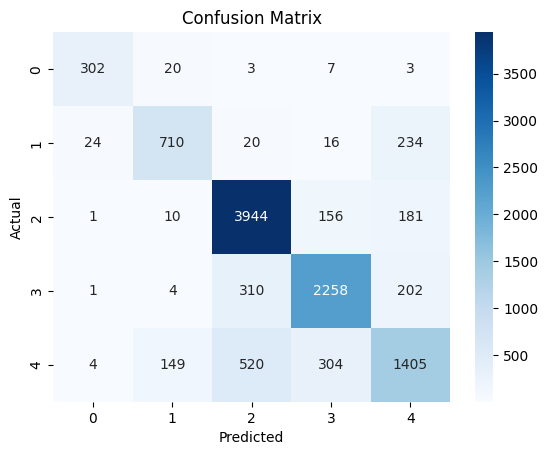

In [61]:
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

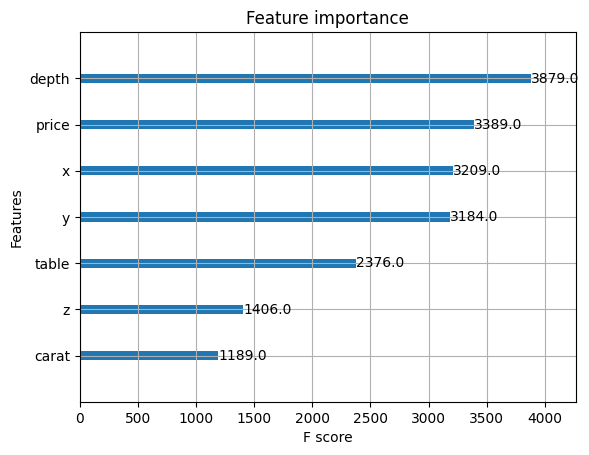

In [62]:
plot_importance(model)
plt.show()

In [63]:
y.value_counts()

cut
Ideal        21551
Premium      13791
Very Good    12082
Good          4906
Fair          1610
Name: count, dtype: int64

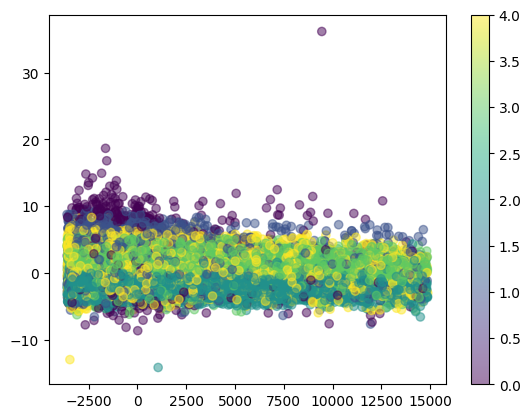

In [64]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train_encoded, cmap='viridis', alpha=0.5)
plt.colorbar()
plt.show()

In [65]:
from collections import Counter

In [66]:
class_counts = Counter(y_train_encoded)
total_samples = len(y_train_encoded)
weights = {cls: total_samples / count for cls, count in class_counts.items()}
sample_weights = [weights[cls] for cls in y_train_encoded]

In [67]:
from sklearn.model_selection import GridSearchCV

In [75]:
model1 = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

param_grid = {
    'max_depth': [3, 5, 7, 9],  # Глубина дерева
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Скорость обучения
    'n_estimators': [100, 200, 300],  # Количество деревьев
    'subsample': [0.7, 0.8, 0.9, 1.0],  # Пропорция выборки для обучения
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],  # Пропорция признаков для обучения дерева
    'gamma': [0, 0.1, 0.2, 0.3],  # Параметр для регуляризации
    'scale_pos_weight': [1, 2, 3]  # Вес для положительного класса
}

grid_search = GridSearchCV(estimator=model1, param_grid=param_grid, 
                           scoring='accuracy', cv=5, verbose=2, n_jobs=-1)


In [76]:
grid_search.fit(X_train, y_train_encoded)

Fitting 5 folds for each of 9216 candidates, totalling 46080 fits


KeyboardInterrupt: 

In [ ]:
best_xgb_model = grid_search.best_estimator_
print("Лучшие параметры:", grid_search.best_params_)

# Прогнозирование
y_pred_xgb_gcv = best_xgb_model.predict(X_test)

In [ ]:
print(classification_report(y_test_encoded, y_pred_xgb_gcv))

### Неудивительно, что градиентный бустинг оказался наилучшим пока

### Осталось сделать гридсерч

In [77]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.1, 0.01, 0.001],
        'n_estimators':[50, 100, 150, 200]
        }

In [78]:
xgb_model = XGBClassifier()

xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=params,
    cv=2,  
    scoring='f1_weighted', 
    verbose=1,  
    n_jobs=4  
)

grid_search.fit(X_train, y_train_encoded)

best_params = grid_search.best_params_
print("Лучшие параметры:", best_params)


Fitting 2 folds for each of 4860 candidates, totalling 9720 fits


KeyboardInterrupt: 

In [ ]:
best_xgb_model = grid_search.best_estimator_

y_pred_xgb_GS = best_xgb_model.predict(X_test)

In [ ]:
print(classification_report(y_test_encoded, y_pred_xgb_GS))

В общем лучше не получилось

# По итогу лучшим по метрикам оказался XGBoost

In [68]:
from sklearn.utils.class_weight import compute_class_weight


In [69]:
unique_classes = np.unique(y_train_encoded)
class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_train_encoded)
class_weights_dict = dict(zip(unique_classes, class_weights))

params = {
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'max_depth': [3, 4],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [50, 100],
    'scale_pos_weight': [1, 10] 
}

xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=params,
    cv=3, 
    scoring='f1_macro', 
    verbose=1,
    n_jobs=-1 
)


In [70]:
grid_search.fit(X_train, y_train_encoded)

best_params = grid_search.best_params_
print("Лучшие параметры:", best_params)

Fitting 3 folds for each of 576 candidates, totalling 1728 fits


G:\Python 3.11\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:20:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Лучшие параметры: {'colsample_bytree': 1.0, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'scale_pos_weight': 1, 'subsample': 0.8}


In [71]:
best_xgb_model = grid_search.best_estimator_

y_pred_xgb_GS = best_xgb_model.predict(X_test)

In [72]:
print(classification_report(y_test_encoded, y_pred_xgb_GS))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       335
           1       0.81      0.63      0.71      1004
           2       0.81      0.92      0.86      4292
           3       0.68      0.86      0.76      2775
           4       0.69      0.38      0.49      2382

    accuracy                           0.76     10788
   macro avg       0.78      0.74      0.75     10788
weighted avg       0.75      0.76      0.74     10788



X_train_scaled, X_test_scaled, y_train, y_test

In [73]:
from sklearn.model_selection import RandomizedSearchCV

In [74]:
rf = RandomForestClassifier(random_state=RANDOM_STATE)
rf.fit(X_train_scaled, y_train)


RandomForestClassifier(random_state=42)

In [75]:
y_pred_rf = rf.predict(X_test_scaled)

In [76]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

        Fair       0.91      0.90      0.90       335
        Good       0.79      0.71      0.75      1004
       Ideal       0.82      0.91      0.86      4292
     Premium       0.78      0.82      0.80      2775
   Very Good       0.68      0.54      0.60      2382

    accuracy                           0.79     10788
   macro avg       0.79      0.78      0.78     10788
weighted avg       0.78      0.79      0.78     10788



И все таки, xgboost оказался самым лучшим

In [77]:
param_distributions = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_distributions,
                                   n_iter=100, 
                                   scoring='f1_weighted',
                                   cv=3, verbose=2, random_state=42, n_jobs=-1)

random_search.fit(X_train_scaled, y_train)

print("Лучшие параметры:", random_search.best_params_)

best_rf_random = random_search.best_estimator_

y_pred_rf_random = best_rf_random.predict(X_test_scaled)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Лучшие параметры: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': None, 'bootstrap': True}


In [78]:
print(classification_report(y_test, y_pred_rf_random))

              precision    recall  f1-score   support

        Fair       0.91      0.90      0.91       335
        Good       0.77      0.70      0.74      1004
       Ideal       0.82      0.92      0.87      4292
     Premium       0.83      0.81      0.82      2775
   Very Good       0.69      0.59      0.63      2382

    accuracy                           0.80     10788
   macro avg       0.80      0.78      0.79     10788
weighted avg       0.79      0.80      0.79     10788



### хотя я уверен, что рандом форест то же может лучше показать себя, но как?

In [79]:
import lightgbm as lgb

In [80]:
lgbc = lgb.LGBMClassifier(random_state=RANDOM_STATE)
lgbc.fit(X_train_scaled, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1516
[LightGBM] [Info] Number of data points in the train set: 43152, number of used features: 7
[LightGBM] [Info] Start training from score -3.521783
[LightGBM] [Info] Start training from score -2.403240
[LightGBM] [Info] Start training from score -0.916395
[LightGBM] [Info] Start training from score -1.365380
[LightGBM] [Info] Start training from score -1.492603


LGBMClassifier(random_state=42)

In [81]:
y_pred_lgbc = lgbc.predict(X_test_scaled)

In [82]:
print(classification_report(y_test, y_pred_lgbc))

              precision    recall  f1-score   support

        Fair       0.92      0.90      0.91       335
        Good       0.80      0.69      0.74      1004
       Ideal       0.82      0.92      0.87      4292
     Premium       0.83      0.81      0.82      2775
   Very Good       0.69      0.60      0.64      2382

    accuracy                           0.80     10788
   macro avg       0.81      0.79      0.80     10788
weighted avg       0.80      0.80      0.80     10788



In [83]:
lgb_params = {
    'num_leaves': [20, 31, 40],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.1, 0.05, 0.01],
    'n_estimators': [50, 100, 200],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_samples': [10, 20, 30]
}


lgb_model = lgb.LGBMClassifier(random_state=42, class_weight='balanced', n_estimators=50)

grid_search = GridSearchCV(
    estimator=lgb_model,
    param_grid=lgb_params,
    scoring='f1_macro', 
    cv=3, 
    verbose=1,
    n_jobs=-1 
)

In [84]:
fit_params = {
    "eval_set": [(X_test, y_test_encoded)],
    "eval_metric": "f1",
    "early_stopping_rounds": 10,
    "verbose": False
}

In [85]:
grid_search.fit(X_train, y_train_encoded)

best_params = grid_search.best_params_
print("Лучшие параметры:", best_params)


Fitting 3 folds for each of 2187 candidates, totalling 6561 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1509
[LightGBM] [Info] Number of data points in the train set: 43152, number of used features: 7
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
Лучшие параметры: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 20, 'min_child_samples': 10, 'n_estimators': 200, 'num_leaves': 40, 'subsample': 0.6}


In [86]:
best_lgb_model = grid_search.best_estimator_

y_pred_lgb = best_lgb_model.predict(X_test)

In [87]:
print(classification_report(y_test_encoded, y_pred_lgb))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       335
           1       0.73      0.81      0.77      1004
           2       0.85      0.89      0.87      4292
           3       0.83      0.81      0.82      2775
           4       0.69      0.61      0.65      2382

    accuracy                           0.80     10788
   macro avg       0.80      0.81      0.80     10788
weighted avg       0.80      0.80      0.80     10788



## А нет, Lgb дал чуть лучше, чем градиентный бустинг

# Пока не знаю, как еще улучшить классификацию, может потом придумаю

# Поэтому буду делать актуальные задания - прегрессия